## stacked model training

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

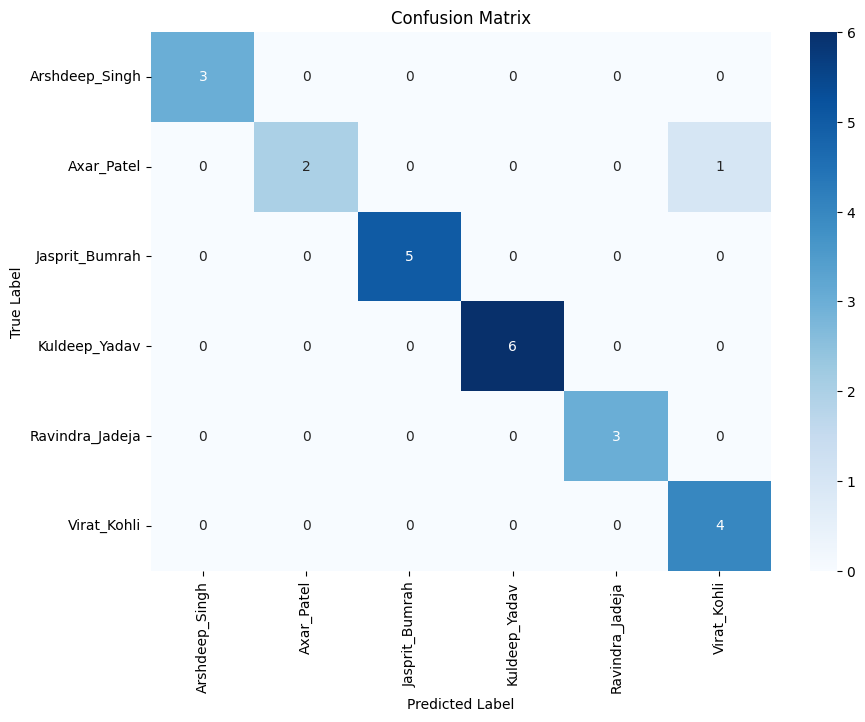

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:1415: RuntimeWarning: Number of classes in training fold (3) does not match total number of classes (4). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:1415: RuntimeWarning: Number of classes in training fold (3) does not match total number of cla

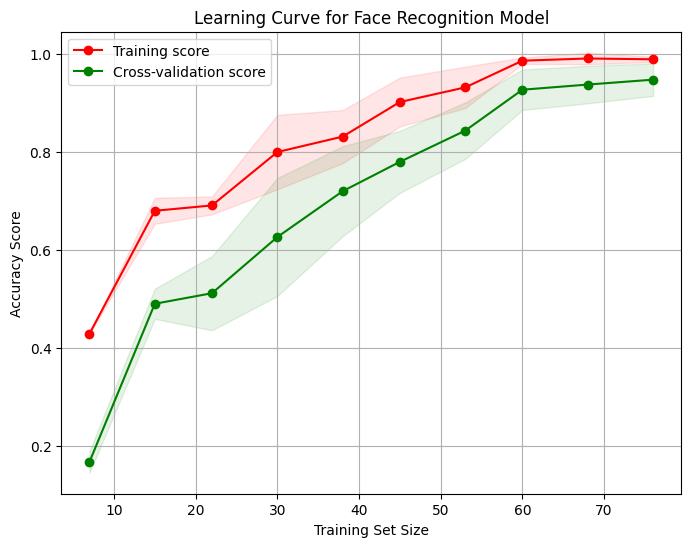

In [12]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.detector = MTCNN()
        self.X = []  # Initialize X attribute
        self.Y = []  # Initialize Y attribute

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        results = self.detector.detect_faces(img)
        if results:
            x, y, w, h = results[0]['box']
            x, y = max(x, 0), max(y, 0)  # Ensure coordinates are non-negative
            face = img[y:y+h, x:x+w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        return None

    def load_faces(self, dir):
        faces = []
        for im_name in os.listdir(dir):
            if im_name.startswith('.'):  # Skip hidden files
                continue
            path = os.path.join(dir, im_name)
            if os.path.isfile(path):  # Ensure it's a file, not a directory
                try:
                    single_face = self.extract_face(path)
                    if single_face is not None:
                        faces.append(single_face)
                except Exception as e:
                    print(f"Error processing {path}: {e}")
            else:
                print(f"Skipping {path}, since it's not a file.")
        return faces

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            if sub_dir.startswith('.'):  # Skip hidden directories/files
                continue
            path = os.path.join(self.directory, sub_dir)
            if os.path.isdir(path):  # Ensure it's a directory
                faces = self.load_faces(path)
                labels = [sub_dir] * len(faces)
                self.X.extend(faces)
                self.Y.extend(labels)
            else:
                print(f"Skipping {path}, since it's not a directory.")
        return np.asarray(self.X), np.asarray(self.Y)

def get_embedding(face_img, embedder):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    yhat = embedder.embeddings(face_img)
    return yhat[0]

# Load dataset
faceloading = FACELOADING("Dataset")
X, Y = faceloading.load_classes()

# Convert lists to NumPy arrays
X = np.asarray(X)
Y = np.asarray(Y)

embedder = FaceNet()
EMBEDDED_X = [get_embedding(img, embedder) for img in X]
EMBEDDED_X = np.asarray(EMBEDDED_X)

# Encode labels
encoder = LabelEncoder()
Y_enc = encoder.fit_transform(Y)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y_enc, test_size=0.2, shuffle=True, random_state=17)


# Train model
# Define the base models
estimators = [
    ('svm', SVC(kernel='rbf', C=1, gamma='scale', probability=True)),
    ('knn', KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform'))
]

# rf = RandomForestClassifier(n_estimators=100)
# knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='uniform')
log_reg_meta = LogisticRegression(C=0.001, penalty='l2', solver='liblinear')

# Define the stacking ensemble
model = StackingClassifier(estimators=estimators, final_estimator=log_reg_meta, cv = 3)
model.fit(X_train, Y_train)

# Save model and encoder
if not os.path.exists('trained_model'):
    os.makedirs('trained_model')
joblib.dump(model, 'trained_model/face_recognition_model.pkl')
joblib.dump(encoder, 'trained_model/label_encoder.pkl')

# Evaluate training accuracy
train_accuracy = model.score(X_train, Y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate test accuracy
test_accuracy = model.score(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate classification report
Y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred, target_names=encoder.classes_))

# Generate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Define the function to plot learning curves
def plot_learning_curves(model, X, y, title='Learning Curves'):
    from sklearn.model_selection import learning_curve

    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10), scoring='accuracy')

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r",  label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    # Draw bands for standard deviation
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curves using the defined function
plot_learning_curves(model, X_train, Y_train, title='Learning Curve for Face Recognition Model')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


KeyboardInterrupt: 

: 

##  original model training

In [ ]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.detector = MTCNN()
        self.X = []  # initialize X attribute
        self.Y = []  # initialize Y attribute

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        results = self.detector.detect_faces(img)
        if results:
            x, y, w, h = results[0]['box']
            face = img[y:y+h, x:x+w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        return None

    def load_faces(self, dir):
        faces = []
        for im_name in os.listdir(dir):
            if im_name.startswith('.'):  
                continue
            path = os.path.join(dir, im_name)
            if os.path.isfile(path): 
                try:
                    single_face = self.extract_face(path)
                    if single_face is not None:
                        faces.append(single_face)
                except Exception as e:
                    print(f"Error processing {path}: {e}")
        return faces

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            if sub_dir.startswith('.'):  
                continue
            path = os.path.join(self.directory, sub_dir)
            if os.path.isdir(path):  
                faces = self.load_faces(path)
                self.X.extend(faces)
                self.Y.extend([sub_dir] * len(faces))
        return np.asarray(self.X), np.asarray(self.Y)


def get_embedding(face_img, embedder):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    yhat = embedder.embeddings(face_img)
    return yhat[0]

# load dataset
faceloading = FACELOADING("Dataset")
X, Y = faceloading.load_classes()

embedder = FaceNet()
EMBEDDED_X = [get_embedding(img, embedder) for img in X]
EMBEDDED_X = np.asarray(EMBEDDED_X)

# encode labels
encoder = LabelEncoder()
Y_enc = encoder.fit_transform(Y)

# train test split
X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y_enc, shuffle=True, random_state=17)

# train model
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

# save model and encoder
joblib.dump(model, 'trained_model/face_recognition_model.pkl')
joblib.dump(encoder, 'trained_model/label_encoder.pkl')

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

['trained_model/label_encoder.pkl']

## Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━

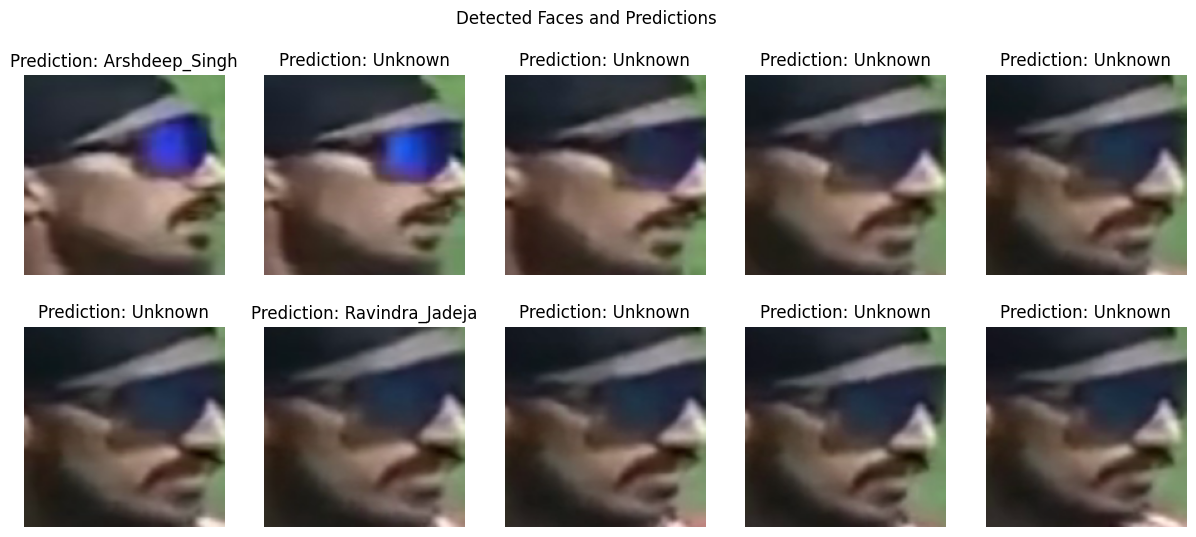


Predicted player: Arshdeep_Singh


In [4]:
import cv2 as cv
import numpy as np
import os
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
import joblib
import matplotlib.pyplot as plt
from collections import Counter

# Ensure TensorFlow logging is controlled
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load the FaceNet model for embeddings
embedder = FaceNet()

# Load the SVM model and label encoder
model = joblib.load('trained_model/face_recognition_model.pkl')
encoder = joblib.load('trained_model/label_encoder.pkl')

# Initialize MTCNN for face detection
detector = MTCNN()

# Function to get embeddings using FaceNet
def get_embedding(face_img):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    return embedder.embeddings(face_img)[0]

# Provide the path to your video file
video_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/test_video/7.mov'  # Replace with the actual path to your video
cap = cv.VideoCapture(video_path)

# Get total number of frames in the video
total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

# Decide on the number of frames to extract
num_frames_to_extract = 10

# Calculate intervals to extract frames evenly
interval = total_frames // num_frames_to_extract if total_frames >= num_frames_to_extract else 1
frame_ids = [interval * i for i in range(num_frames_to_extract)]

processed_faces = []
predictions = []

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count in frame_ids:
        rgb_img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

        # Detect faces in the frame
        results = detector.detect_faces(rgb_img)
        if results:
            for result in results:
                x, y, w, h = result['box']
                x, y = max(0, x), max(0, y)  # Ensure coordinates are within the image
                face = rgb_img[y:y+h, x:x+w]
                face = cv.resize(face, (160, 160))

                # Generate embedding for the detected face
                embedding = get_embedding(face)
                embedding = np.expand_dims(embedding, axis=0)

                # Predict the identity of the face
                ypred = model.predict(embedding)
                proba = model.predict_proba(embedding).max()
                if proba > 0.5:  # Confidence threshold
                    final_name = encoder.inverse_transform(ypred)[0]
                else:
                    final_name = "Unknown"

                # Collect the processed face and prediction
                processed_faces.append(face)
                predictions.append(final_name)

                # Break after processing the first face in the frame
                break
        else:
            print(f"No face detected in frame {frame_count}.")

    frame_count += 1

    # Early exit if we've processed all required frames
    if len(processed_faces) >= num_frames_to_extract:
        break

cap.release()

# Now, use matplotlib to display the final cropped images and predictions
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # Adjust subplot grid and size as needed
fig.suptitle('Detected Faces and Predictions')

for idx, ax in enumerate(axs.flatten()):
    if idx < len(processed_faces):
        ax.imshow(processed_faces[idx])
        ax.set_title(f"Prediction: {predictions[idx]}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

# Determine the most frequently predicted player
if predictions:
    # Exclude "Unknown" from the counts if present
    filtered_predictions = [pred for pred in predictions if pred != "Unknown"]
    if filtered_predictions:
        most_common_prediction = Counter(filtered_predictions).most_common(1)[0][0]
    else:
        most_common_prediction = "Unknown"
    print(f"\nPredicted player: {most_common_prediction}")
else:
    print("\nNo predictions were made.")


## Live video inference

In [1]:
import cv2 as cv
import numpy as np
import os
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
import joblib

# Ensure TensorFlow logging is controlled
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load the FaceNet model for embeddings
embedder = FaceNet()

# Load the SVM model and label encoder
model = joblib.load('trained_model/face_recognition_model.pkl')
encoder = joblib.load('trained_model/label_encoder.pkl')

# Initialize MTCNN for face detection
detector = MTCNN()

# Function to get embeddings using FaceNet
def get_embedding(face_img):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    return embedder.embeddings(face_img)[0]

# Select webcam;
cap = cv.VideoCapture(0) 

while cap.isOpened():
    _, frame = cap.read()
    rgb_img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

    # Detect faces in the frame
    results = detector.detect_faces(rgb_img)
    for result in results:
        x, y, w, h = result['box']
        face = rgb_img[y:y+h, x:x+w]
        face = cv.resize(face, (160, 160))

        # Generate embedding for the detected face
        embedding = get_embedding(face)
        embedding = np.expand_dims(embedding, axis=0)

        # Predict the identity of the face
        ypred = model.predict(embedding)
        if model.predict_proba(embedding).max() > 0.5:  # Confidence threshold
            final_name = encoder.inverse_transform(ypred)[0]
        else:
            final_name = "Unknown"

        # Display the identity and a bounding box around the face
        cv.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)
        cv.putText(frame, str(final_name), (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv.LINE_AA)

    cv.imshow("Face Recognition", frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2024-11-04 22:36:36.754 Python[10714:307029] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


KeyboardInterrupt: 

: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


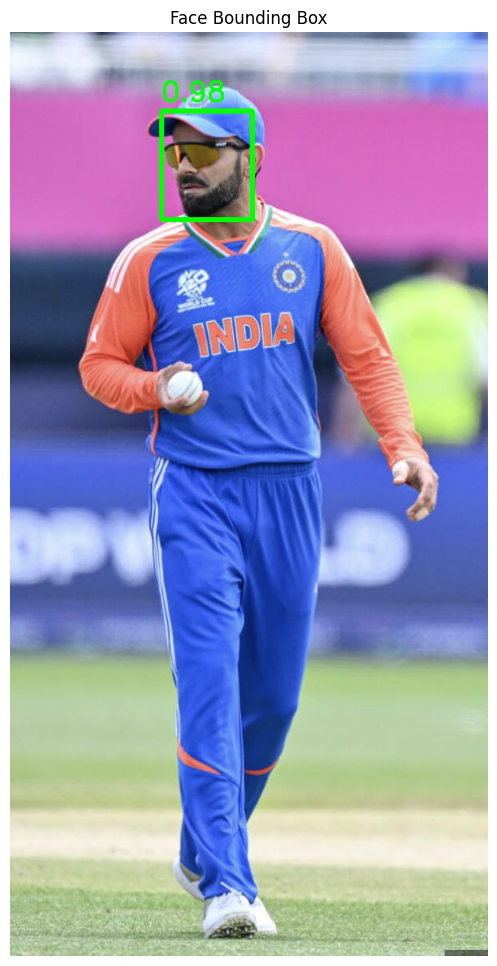

In [11]:
import cv2 as cv
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

# Load image
image_path = "/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/resnet_data/Virat_Kohli/Screenshot 2024-08-16 at 12.08.35.png"
img = cv.imread(image_path)
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
h_img, w_img, _ = img_rgb.shape

# Initialize MTCNN
detector = MTCNN()
results = detector.detect_faces(img_rgb)

# Draw bounding boxes
if results:
    for res in results:
        x, y, w, h = res['box']
        confidence = res['confidence']

        # Expand the bounding box by 20% on each side
        padding_x = int(w * 0.25)
        padding_y = int(h * 0.25)
        
        x1 = max(0, x - padding_x)
        y1 = max(0, y - padding_y)
        x2 = min(w_img, x + w + padding_x)
        y2 = min(h_img, y + h + padding_y)

        # Draw rectangle in green with thicker border
        cv.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), thickness=3)

        # Annotate confidence
        cv.putText(img_rgb, f"{confidence:.2f}", (x1, y1 - 10),
                   cv.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Show image
plt.figure(figsize=(10, 12))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Face Bounding Box")
plt.show()
